<a href="https://colab.research.google.com/github/mxxndust/ML/blob/main/LabTimeSeriesLR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

*Код, генерирующий временной ряд с трендом, сезонностью и шумом:*

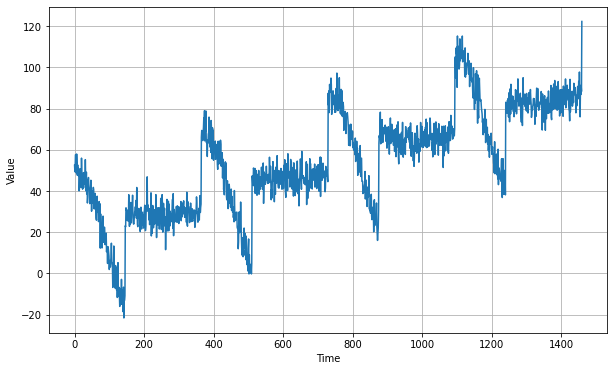

In [11]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

time = np.arange(4 * 365 + 1, dtype="float32")

series = trend(time, 0.1)  
baseline = 10
amplitude = 40
slope = 0.05
noise_level = 5

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# Update with noise
series += noise(time, noise_level, seed=42)

plt.figure(figsize=(10, 6))
plot_series(time, series)
plt.show()

*Создание функции windowed_dataset:*

In [12]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

*Код для подготовки тренировочного и валидационного наборов, их графики:*

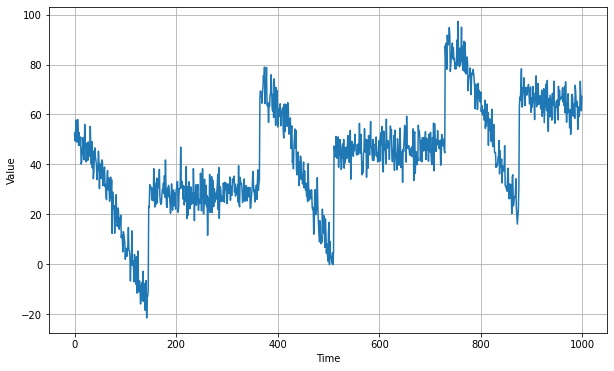

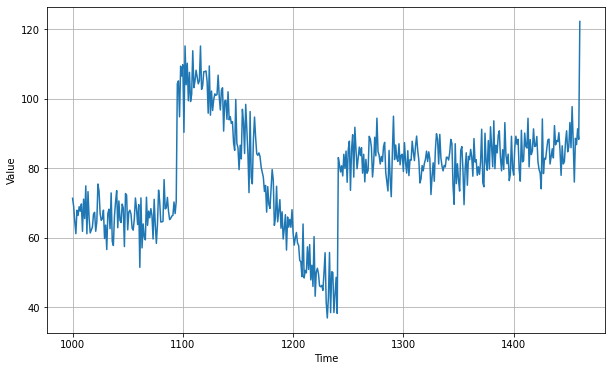

In [13]:
split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

plt.figure(figsize=(10, 6))
plot_series(time_train, x_train)
plt.show()

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plt.show()

*Создания однослойной нейронной сети:*

In [14]:
window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
l0 = tf.keras.layers.Dense(1, input_shape=[window_size])
model = tf.keras.models.Sequential([l0])

In [15]:
#model.compile(loss="mae", optimizer=tf.keras.optimizers.SGD(lr=1e-6, decay=1e-6, momentum=0.9, nesterov=True)) 
model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(lr=1e-5, momentum=0.2))
model.fit(dataset, epochs=100, verbose=0)

print("LW {}".format(l0.get_weights()))

LW [array([[-0.03359278],
       [-0.0334949 ],
       [ 0.07671117],
       [-0.01089288],
       [ 0.03018009],
       [-0.06130907],
       [ 0.02805309],
       [ 0.02369279],
       [ 0.01655621],
       [-0.03796081],
       [ 0.0371882 ],
       [-0.06776512],
       [ 0.00802691],
       [ 0.08607898],
       [-0.01908008],
       [ 0.04076859],
       [-0.00949118],
       [ 0.22322847],
       [ 0.30809826],
       [ 0.4068854 ]], dtype=float32), array([0.01903236], dtype=float32)]


In [16]:
print(series[1:1 + window_size])
model.predict(series[1:1 + window_size][np.newaxis])

[49.35275  53.314735 57.711823 48.934444 48.931244 57.982895 53.897125
 47.67393  52.68371  47.591717 47.506374 50.959415 40.086178 40.919415
 46.612473 44.228207 50.720642 44.454983 41.76799  55.980938]


array([[48.25839]], dtype=float32)

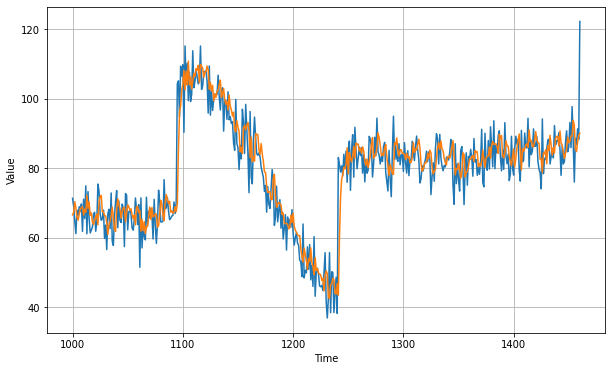

In [17]:
forecast = []

for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time - window_size:]
results = np.array(forecast)[:, 0, 0]

plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

*Вычисление среднеквадратической ошибки и средней абсолютной ошибки:*

In [18]:
print(keras.metrics.mean_squared_error(x_valid, results).numpy())
print(keras.metrics.mean_absolute_error(x_valid, results).numpy())

44.434597
4.9810514
